<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template and tests for an LSTM Auto-Encoder


In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
tf.__version__

'2.2.0'

In [4]:
import tensorflow_datasets as tfds

In [5]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
import copy

In [6]:
import numpy
numpy.__version__


'1.18.1'

In [7]:
# ! pip install tensorflow-probability==0.11.0
! pip install --user -e /global/homes/v/vboehm/codes/SDSS_PAE/    

Obtaining file:///global/homes/v/vboehm/codes/SDSS_PAE
  Attempting uninstall: sdss-pae
    Found existing installation: sdss-pae 0.1.0
    Uninstalling sdss-pae-0.1.0:
      Successfully uninstalled sdss-pae-0.1.0
  Running setup.py develop for sdss-pae


In [8]:
a = np.arange(4)
ind = np.where([0,1,0,1])
a[ind]

array([1, 3])

In [9]:
### settings
# user defined span (following Yip et al and Portillo et al)
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'

root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'
root_data       = '/global/cscratch1/sd/vboehm/Datasets'

root_prepped    = os.path.join(root_data,'sdss/prepped')

wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.05
max_z           = 0.36
label           = 'galaxies_quasars_bins1000_wl3388-8318'
label_          = label+'_minz005_maxz036_minSN50'

In [10]:
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

In [11]:
target, MJD_t, plate_t, fiber_t, objid_t = np.load(os.path.join(root_data,'SDSS_BOSS_data/target_selection.npy'))
obj = [[MJD_t[ii], plate_t[ii], fiber_t[ii]] for ii in range(len(target))]

In [12]:
for nn in range(6):
    print(nn)
    arrays = [np.asarray([[],[]]) for jj in range(12)]
    array_ = np.load(os.path.join(root_data,'SDSS_BOSS_preprocessed/%s_%d_target_selection.npy'%(label,nn)), allow_pickle=True)
    for jj in range(12):
        arr = np.vstack(array_[jj])
        arrays[jj] = np.append(arrays[jj],arr)
    res_fluxes_,res_inv_vars_,res_masks_,redshifts_,SNs_, ras_, decs_, category_,sublabel_, MJD_, plate_id_, fiber_ = arrays
    if nn==0:
        res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel, MJD, plate_id, fiber = res_fluxes_, res_masks_, res_inv_vars_, redshifts_, SNs_, ras_, decs_, category_, sublabel_, MJD_, plate_id_, fiber_
    else:
            res_fluxes   = np.concatenate([res_fluxes, res_fluxes_],axis=0)
            res_masks    = np.concatenate([res_masks, res_masks_],axis=0)
            res_inv_vars = np.concatenate([res_inv_vars, res_inv_vars_],axis=0)
            redshifts    = np.concatenate([redshifts, redshifts_],axis=0)
            SNs          = np.concatenate([SNs, SNs_],axis=0)
            ras          = np.concatenate([ras, ras_],axis=0)
            decs         = np.concatenate([decs, decs_],axis=0)
            category     = np.concatenate([category, category_],axis=0)
            sublabel     = np.concatenate([sublabel, sublabel_],axis=0)
            MJD          = np.concatenate([MJD, MJD_],axis=0)
            plate_id     = np.concatenate([plate_id, plate_id_],axis=0)
            fiber        = np.concatenate([fiber, fiber_],axis=0)   

0
1
2
3
4
5


In [13]:
res_fluxes_ = np.reshape(res_fluxes,[-1,1000])
res_inv_vars_ =  np.reshape(res_inv_vars,[-1,1000])
res_masks_ =  np.reshape(res_masks,[-1,1000])

In [14]:
redshifts_, ras_, decs_, category_, sublabel_, MJD_, plate_id_, fiber_ = redshifts, ras, decs, category, sublabel, MJD, plate_id, fiber

In [15]:
import pandas as pd

In [16]:
df1 = pd.DataFrame()
df1['MJD']   = MJD_
df1['plate'] = plate_id_
df1['fiber'] = fiber_
df1['redshift'] = redshifts_
df1['num']   = np.arange(len(MJD_))

df2 = pd.DataFrame()
df2['MJD']   = MJD_t
df2['plate'] = plate_t
df2['fiber'] = fiber_t
df2['objid'] = objid_t

df_overlap=df1.merge(df2,how='inner',on=['plate','MJD','fiber'])

select = df_overlap['num']
print(len(select), max(select), len(res_fluxes_))

236769 721672 721679


In [17]:
print(df_overlap[(df_overlap['plate']==267)*(df_overlap['MJD']==51608)*(df_overlap['fiber']==9)])
print(df_overlap[(df_overlap['objid']==300617776005933056)])



           MJD  plate  fiber  redshift     num               objid
47564  51608.0  267.0    9.0  0.292146  144373  300617776005933056
           MJD  plate  fiber  redshift     num               objid
47564  51608.0  267.0    9.0  0.292146  144373  300617776005933056


/global/homes/v/vboehm/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


In [32]:
def target_select(indx, x):
    num = len(x)
    arrays_new = [x[ii][indx] for ii in range(num)]
    print('new datasize: ', len(indx))
    return arrays_new

res_fluxes, res_masks, res_inv_vars, redshifts, ras, decs, category, sublabel, MJD, plate_id, fiber = target_select(select, [res_fluxes_, res_masks_, res_inv_vars_, redshifts_, ras_, decs_, category_, sublabel_, MJD_, plate_id_, fiber_])

new datasize:  236769


In [37]:
print(redshifts[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])
print(df_overlap['objid'][np.where((MJD==51608)*(plate_id==267)*(fiber==9))[0]]==300617776005933056)
print(category[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])
print(ras[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])
print(decs[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])

[0.29214615]
47564    True
Name: objid, dtype: bool
[2.]
[148.82977295]
[-0.74093264]


In [51]:
df_overlap['objid'].to_numpy().shape

(236769,)

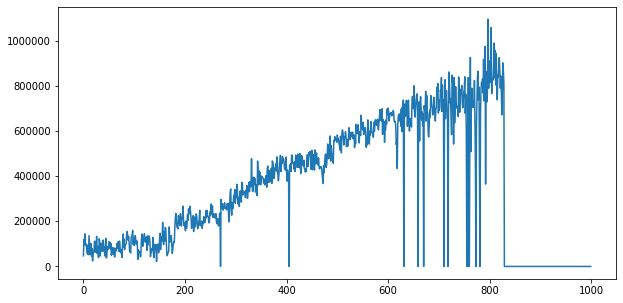

In [39]:
plt.figure(figsize=(10,5))
plt.plot(res_fluxes[np.where((MJD==51608)*(plate_id==267)*(fiber==9))[0]][0])

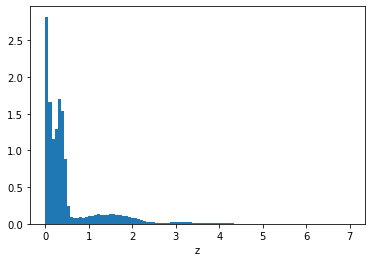

In [40]:
_ = plt.hist(redshifts,bins=100,density=True)
plt.xlabel('z')
plt.show()

In [67]:
def redshift_bin(min_z, max_z, z_array, arrays):
    num  = len(arrays)
    indx = np.where((redshifts>min_z)*(redshifts<max_z))[0]
    arrays_new = [arrays[ii][indx] for ii in range(num)]
    print('new datasize: ', len(indx))
    return arrays_new

res_fluxes, res_masks, res_inv_vars, redshifts, ras, decs, category, sublabel, MJD, plate_id, fiber, objid = redshift_bin(min_z, max_z, redshifts, [res_fluxes, res_masks, res_inv_vars, redshifts, ras, decs, category, sublabel, MJD, plate_id, fiber, df_overlap['objid'].to_numpy()])

new datasize:  112165


In [68]:
DATASET_SIZE = len(res_fluxes)

In [69]:
print(redshifts[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])
print(df_overlap['objid'][np.where((MJD==51608)*(plate_id==267)*(fiber==9))[0]]==300617776005933056)
print(category[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])
print(ras[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])
print(decs[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])

[0.29214615]
22303    False
Name: objid, dtype: bool
[2.]
[148.82977295]
[-0.74093264]


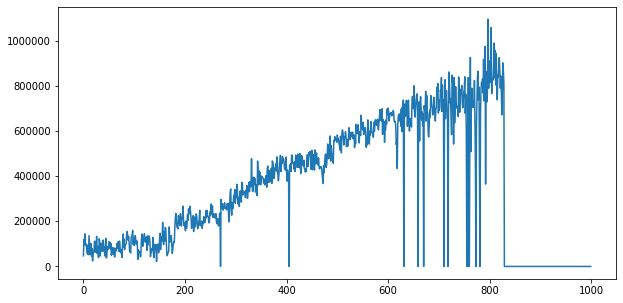

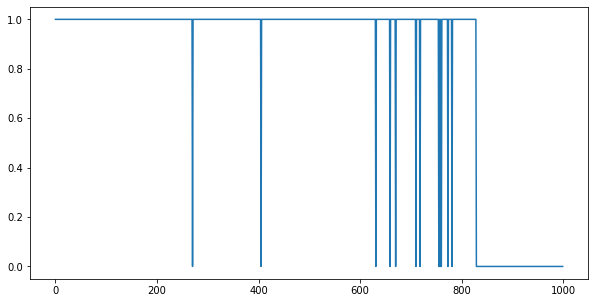

In [73]:
plt.figure(figsize=(10,5))
plt.plot(res_fluxes[np.where((MJD==51608)*(plate_id==267)*(fiber==9))[0]][0])

plt.show()

plt.figure(figsize=(10,5))
plt.plot(res_masks[np.where((MJD==51608)*(plate_id==267)*(fiber==9))[0]][0])


plt.show()

In [74]:
boolean_mask = (res_masks==0)

In [75]:
mask_fracs = np.mean(boolean_mask,axis=1)

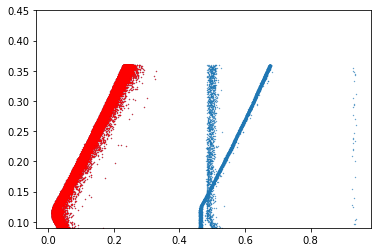

In [78]:
plt.scatter(mask_fracs, redshifts, s=0.1)
# plt.plot(mask_fracs,mask_fracs*1.15+0.19, color='orange')
# keep = redshifts>mask_fracs*1.15+0.19
# keep_low = mask_fracs<0.04
# keep = np.logical_or(keep,keep_low)
keep = mask_fracs<0.4
plt.scatter(mask_fracs[keep], redshifts[keep], color='red', s=0.1)
plt.ylim(0.09,0.45)
plt.show()

In [79]:
len(keep)

112165

In [80]:
def mask_bin(keep, arrays):
    num  = len(arrays)
    arrays_new = [arrays[ii][keep] for ii in range(num)]
    print('new datasize: ', len(arrays_new[0]))
    return arrays_new

res_fluxes, res_masks, res_inv_vars, redshifts, ras, decs, category, sublabel,MJD, plate_id, fiber, objid = mask_bin(keep, [res_fluxes, res_masks, res_inv_vars, redshifts, ras, decs, category, sublabel, MJD, plate_id, fiber, objid])

new datasize:  100449


In [81]:
DATASET_SIZE=len(res_fluxes)

In [82]:
SNs =[]
for ii in range(DATASET_SIZE):
    SNs.append(np.sum(res_fluxes[ii][np.where(res_masks[ii])])/np.sqrt(np.sum(1./res_inv_vars[ii][np.where(res_masks[ii])])))
SNs= np.asarray(SNs)

In [83]:
for ii in np.where(np.isnan(SNs))[0]:
    print(np.sum(1./res_inv_vars[ii][np.where(res_masks[ii])]))
    print(len(np.where(res_masks[ii])[0]))

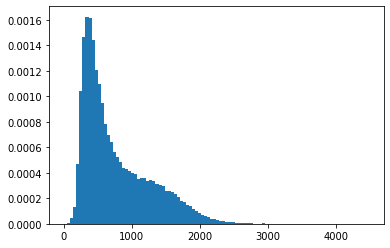

In [84]:
_ = plt.hist(SNs, density=True,bins=100)

In [85]:
new_noise = np.zeros_like(res_inv_vars)
maximum=0
for ii in range(len(new_noise)):
    pix_SNR       = res_fluxes[ii][np.where(res_masks[ii])]/np.sqrt(1./res_inv_vars[ii][np.where(res_masks[ii])])
    new_noise_    = res_inv_vars[ii][np.where(res_masks[ii])][:]
    if np.any(pix_SNR>50.):
        array =(50./res_fluxes[ii][np.where(res_masks[ii])][np.where(pix_SNR>50.)])**2
        new_noise_[np.where(pix_SNR>50.)]=array
    new_noise[ii][np.where(res_masks[ii])] = new_noise_
    if np.any(pix_SNR>50.):
        test = res_fluxes[ii][np.where(res_masks[ii])]/np.sqrt(1./new_noise[ii][np.where(res_masks[ii])])
        if max(test[np.where(pix_SNR>50.)])>maximum:
            maximum=max(test[np.where(pix_SNR>50.)])
            print(ii)


0
75


In [86]:
print(maximum)

50.000000000000014


In [87]:
SNs_corr =[]
for ii in range(DATASET_SIZE):
    SNs_corr.append(np.sum(res_fluxes[ii][np.where(res_masks[ii])])/np.sqrt(np.sum(1./new_noise[ii][np.where(res_masks[ii])])))
SNs_corr= np.asarray(SNs_corr)

In [88]:
max_snr=0
for ii in range(len(res_fluxes)):
    pix_SNR       = res_fluxes[ii][np.where(res_masks[ii])]/np.sqrt(1./new_noise[ii][np.where(res_masks[ii])])
    if max(pix_SNR)>max_snr:
        max_snr=max(pix_SNR)
print(max_snr)

50.000000000000014


In [89]:
max(SNs_corr)

1535.4987998305614

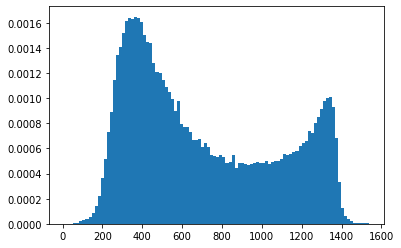

In [90]:
_ = plt.hist(SNs_corr, density=True,bins=100)

Text(0.5, 0, 'S/N')

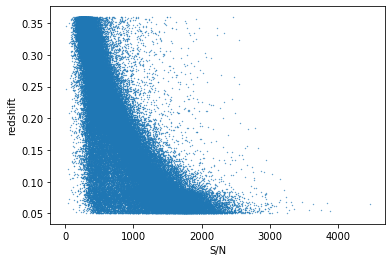

In [91]:
plt.scatter(SNs,redshifts, s=0.1)
plt.ylabel('redshift')
plt.xlabel('S/N')

Text(0.5, 0, 'S/N')

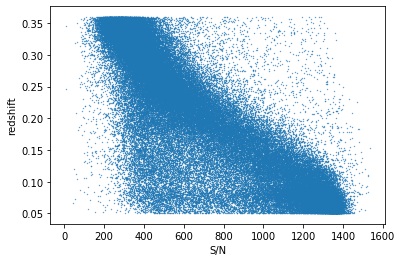

In [92]:
plt.scatter(SNs_corr,redshifts, s=0.1)
plt.ylabel('redshift')
plt.xlabel('S/N')

In [94]:
print(redshifts[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])
print(objid[np.where((MJD==51608)*(plate_id==267)*(fiber==9))[0]]==300617776005933056)
print(category[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])
print(ras[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])
print(decs[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])

[0.29214615]
[ True]
[2.]
[148.82977295]
[-0.74093264]


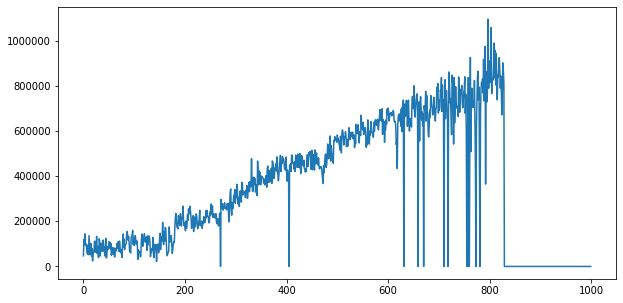

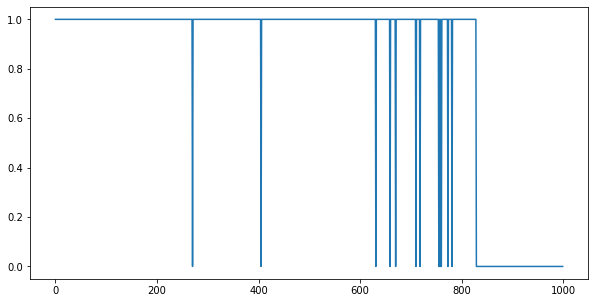

In [95]:
plt.figure(figsize=(10,5))
plt.plot(res_fluxes[np.where((MJD==51608)*(plate_id==267)*(fiber==9))[0]][0])

plt.show()

plt.figure(figsize=(10,5))
plt.plot(res_masks[np.where((MJD==51608)*(plate_id==267)*(fiber==9))[0]][0])


plt.show()

In [96]:
SNs.shape, redshifts.shape, MJD.shape

((100449,), (100449,), (100449,))

In [97]:
def SN_bin(min_SN,  SNs, arrays):
    num  = len(arrays)
    indx = np.where((SNs>min_SN))[0]
    arrays_new = [arrays[ii][indx] for ii in range(num)]
    print('new datasize: ', len(indx))
    return arrays_new

res_fluxes, res_masks, new_noise, redshifts, SNs, ras, decs, category, sublabel, MJD, plate_id, fiber, objid = SN_bin(min_SN, SNs_corr, [res_fluxes, res_masks, new_noise, redshifts,SNs,ras, decs, category, sublabel, MJD, plate_id, fiber, objid])

new datasize:  100445


In [98]:
boolean_mask = (res_masks==0)

In [99]:
mask_fracs = np.mean(boolean_mask,axis=1)
max(mask_fracs)

0.328

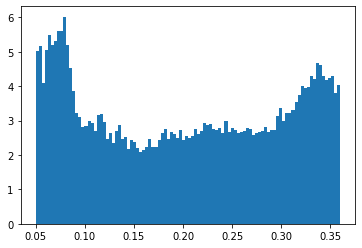

In [100]:
_ = plt.hist(redshifts, density=True, bins=100)

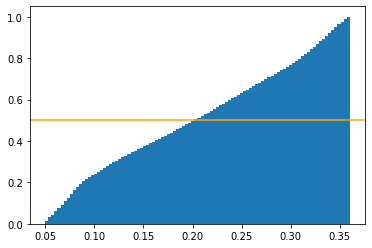

In [101]:
_ = plt.hist(redshifts, density=True, bins=100, cumulative=True)
plt.axhline(0.5,color='orange')

In [102]:
print(redshifts[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])
print(objid[np.where((MJD==51608)*(plate_id==267)*(fiber==9))[0]]==300617776005933056)
print(category[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])
print(ras[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])
print(decs[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])

[0.29214615]
[ True]
[2.]
[148.82977295]
[-0.74093264]


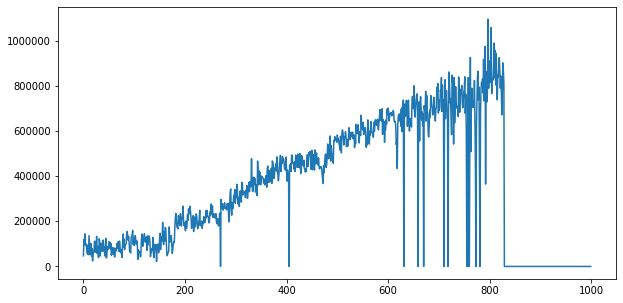

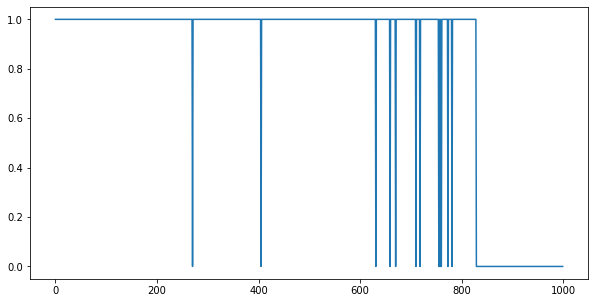

In [103]:
plt.figure(figsize=(10,5))
plt.plot(res_fluxes[np.where((MJD==51608)*(plate_id==267)*(fiber==9))[0]][0])

plt.show()

plt.figure(figsize=(10,5))
plt.plot(res_masks[np.where((MJD==51608)*(plate_id==267)*(fiber==9))[0]][0])


plt.show()

In [104]:
print(MJD[0],plate_id[0], fiber[0],ras[0], decs[0], redshifts[0], category[0], sublabel[0])
#fiber always one too low

53473.0 2108.0 50.0 181.9969024658203 37.638492584228516 0.10390836745500565 2.0 b''


In [105]:
np.save(os.path.join(root_prepped,'prepped_data_spectra_%s_select.npy'%(label_)), [res_fluxes, res_masks, new_noise])

np.save(os.path.join(root_prepped,'prepped_data_prop_%s_select.npy'%(label_)), [redshifts, SNs, ras, decs, category, sublabel, MJD, plate_id, fiber, objid])